In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import seaborn as sns
from tqdm.notebook import tqdm

**Comments not up to date yet**

# *Simple univariate example of a normalizing flow*

*Problem description*

Consider the target variable X to be defined as : $$X\sim \mathcal{N}(\mu_X ; \sigma_X)$$ with parameters $$ \mu_X \text{ and } \sigma_X \text{fixed but unknown.} $$ We will use a transformation such that $$ T(u)  = A.u + b $$


In [74]:
#The true values unkown to the simulator
mu_x = 3
sigma_x = 0.5
N = 1000
N_test = 10*N

prior = torch.distributions.Normal(loc=torch.Tensor([0.0]), scale=torch.Tensor([1.0]))
def gen_observations(number_of_observations:int):
    """Generates a tensor of observations, i.e. x drawn from a normal distribution having mu=mu_x and sigma=sigma_x

    Args:
        number_of_observations (int): Number of obs to generates

    Returns:
        torch.tensor : Tensor of observations
    """  
    #Generating observations from the true distribution
    X = torch.distributions.Normal(loc=mu_x,scale=sigma_x).sample((number_of_observations, ))
    return X
X=gen_observations(N)
X_test = gen_observations(N_test)

In [174]:

class T(nn.Module):
    """Transformation T(u) = A.u + b

    Args:
        None
        
    """
    
    def __init__(self, alpha, b, prior):
        """Init the linear transformer u -> Au +b 

        Args:
            alpha (Float): log(weight)
            b (Float): biais
            prior (torch.distributions): Prior simple to sample from e.g. Normal
        """
        super(T, self).__init__()
        self.b = nn.Parameter(torch.Tensor([b]), requires_grad=True)
        self.alpha = nn.Parameter(torch.Tensor([alpha]), requires_grad=True)
        self.prior = prior
    
    def forward(self,x:torch.tensor):
        """Compute the linear transformation Ax + b

        Args:
            x (torch.tensor)

        Returns:
            torch.tensor A*x + b
        """
        
        z = torch.exp(self.alpha) * x + self.b
        return z,self.alpha

    def reverse(self,x):
        return (x-self.b)/(torch.exp(self.alpha))
    
    def L(self, x): 
        """Compute the loss using the change of variable formula
        """
        z,logdet_J = self.forward(x)
        logprob = self.prior.log_prob(self.reverse(x)).mean()
        res =  logdet_J - logprob

        return  res.mean()
    
    def sample(self, size : tuple):
        """Generates U from the prior and returns T(u)

        Args:
            size (tuple): Size of the desired sample. Must be a tuple

        Returns:
            torch.Tensor
        """
        U = self.prior.sample(size)
        z = self.forward(U)[0]
        return z

In [175]:
n_iter = 20000 #Number of iteration
transformation = T( 1, 1, torch.distributions.Normal(torch.Tensor([0.0]),torch.Tensor([1.0]))) #Instanciation 
learning_rate = 1e-3
optimizer = torch.optim.SGD(transformation.parameters(), learning_rate)
optimizer = torch.optim.Adam(transformation.parameters(), learning_rate)

In [176]:
# Keeping records of these values for later visualisations
losses_train = []
estimated_A = []
estimated_b = []

stable_loss = False
epsilon = 1e-5 # IF distance(Loss(test_time_k) ; (test_time_k+1)) < epsilon we stop the training, the convergence is "achieved"
with torch.no_grad():
    previous_loss_test = transformation.L(X_test).mean().detach().item()
    
for i in range(n_iter):
    
    #Computing train loss
    loss_train = transformation.L(X)
    losses_train.append(loss_train.detach().item())
    
    #Optimizaton steps
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    
    #Keeping records of the estimated parameters
    A_hat, b_hat = torch.exp(transformation.alpha).detach().item(), transformation.b.detach().item()
    estimated_A.append(A_hat)
    estimated_b.append(b_hat)
    if i%500 == 0:
        print(f"Iter {i}, loss = {loss_train}")
    #Is convergence achieved?
    if i%10 ==0: #We check the convergence every ten iterations
        with torch.no_grad():
            loss_test = transformation.L(X_test).mean().detach().item() #Loss on the test batch
        stable_loss = abs(loss_test - previous_loss_test) < epsilon
        if stable_loss:
            print(f"Early stop at iteration {i}")
            break
        previous_loss_test = loss_test

Iter 0, loss = 2.208108425140381
Iter 500, loss = 1.8626750707626343
Iter 1000, loss = 1.4111133813858032
Iter 1500, loss = 0.8776131868362427
Iter 2000, loss = 0.7605656385421753
Early stop at iteration 2230


In [177]:
A_hat, b_hat = estimated_A[-1], estimated_b[-1] 

sample_mean = torch.mean(X)
sample_sigma = torch.std(X, unbiased=False)

print(f" Sample mean = {sample_mean} and b_hat = ", b_hat)
print(f" Sample std = {sample_sigma} and A_hat = ", A_hat)
print(f" Final training loss = ", losses_train[-1])

 Sample mean = 3.001377820968628 and b_hat =  3.0003061294555664
 Sample std = 0.5175613164901733 and A_hat =  0.5180341601371765
 Final training loss =  0.7603143453598022


As expected, the estimated expectation (resp. standard deviation) converges to the sample expectation (resp. standard deviation)

## Visualisation

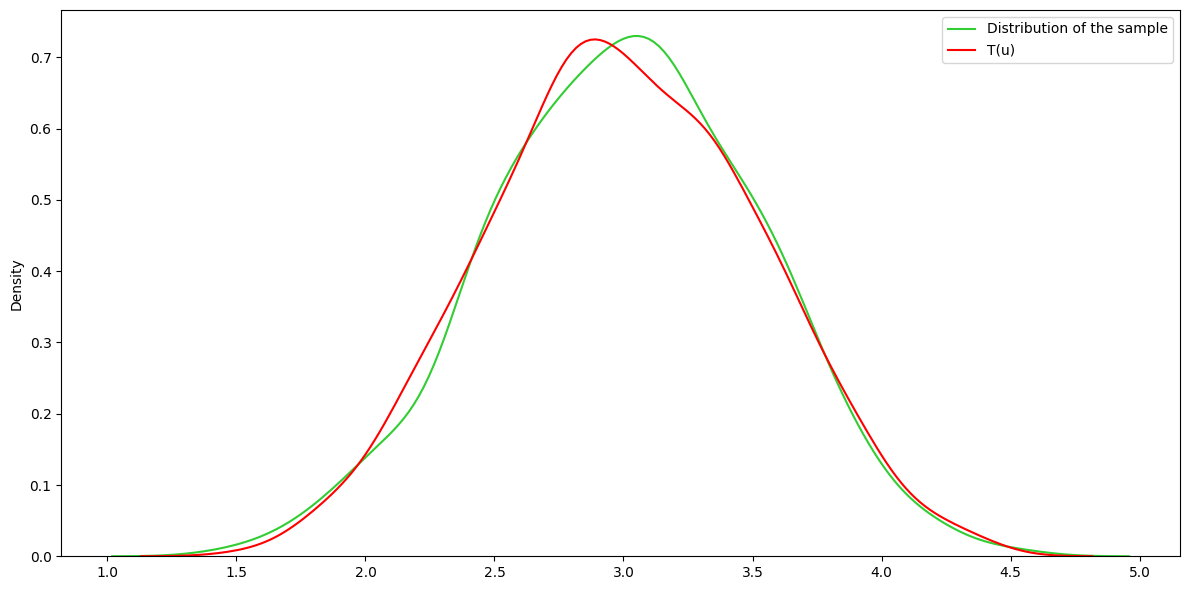

In [7]:
U = torch.distributions.Normal(0, 1).sample((N,1)) # True std Gaussian
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(data=X.squeeze(),
            label='Distribution of the sample', ax=ax, color='limegreen')
sns.kdeplot(data= transformation.sample( (N , )).detach().squeeze(), ax = ax, color='red', label='T(u)')


ax.legend()
plt.tight_layout()
plt.show()

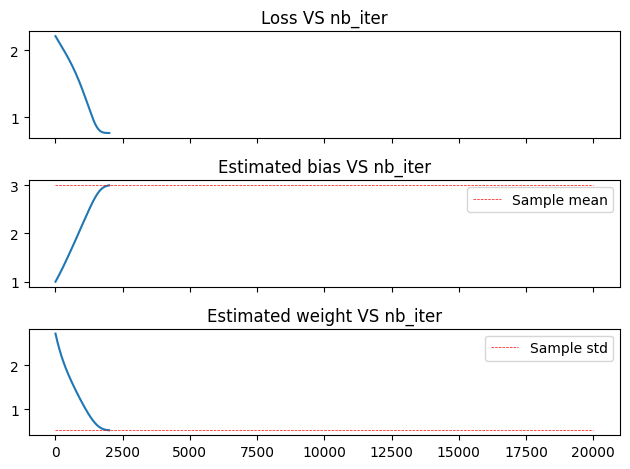

In [8]:
fig, axs = plt.subplots(3, sharex = True)
axs[0].plot(losses_train)
axs[0].set_title("Loss VS nb_iter")
axs[1].plot(estimated_b)
axs[1].hlines(y=sample_mean,xmin=0, xmax=n_iter, linewidth=0.5, color='r', label="Sample mean", linestyles='dashed')
axs[1].legend()
axs[1].set_title("Estimated bias VS nb_iter")
axs[2].plot(estimated_A)
axs[2].hlines(y=sample_sigma,xmin=0, xmax=n_iter, linewidth=0.5, color='r', label="Sample std", linestyles='dashed')
axs[2].legend()
axs[2].set_title("Estimated weight VS nb_iter")
fig.tight_layout()

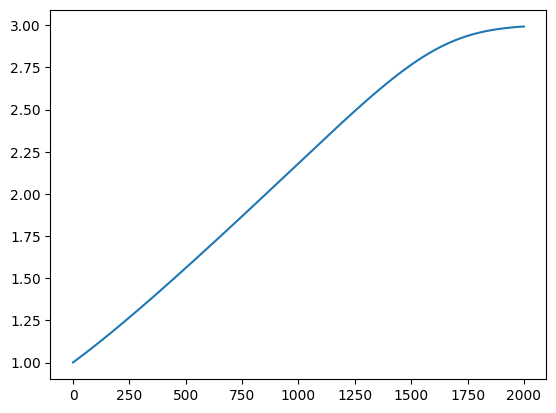

In [9]:
plt.plot(estimated_b)

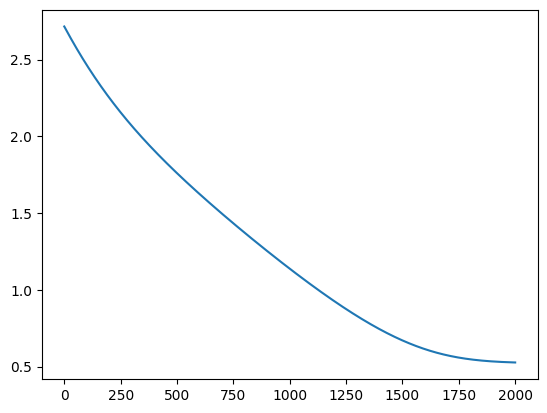

In [10]:
plt.plot(estimated_A)

### Let us compute the loss on a training set

In [11]:
with torch.no_grad():
    loss_t = transformation.L(X_test).mean()
print(loss_t)
losses_train[-1] # Pas grande différence avec la final loss sur le train

tensor(0.7330)


0.7689601182937622

## Effect of sample size

In [12]:
n_iter = 20000 #Number of iteration
transformation = T( 1, 1, torch.distributions.Normal(torch.Tensor([0.0]),torch.Tensor([1.0]))) #Instanciation
learning_rate = 1e-3
optimizer = torch.optim.SGD(transformation.parameters(), learning_rate)
optimizer = torch.optim.Adam(transformation.parameters(), learning_rate)

In [13]:
sample_sizes = []
estimated_A_avg = []
estimated_b_avg = []
sample_mean_avg = []
sample_sigma_avg = []
n_iter = 20000
for sample_size in range(10,1000,50): #Size of the observed data
    print(f" Sample size = {sample_size}")
    sample_sizes.append(sample_size) #Saving for later plots

    current_size_A_hat = []
    current_size_b_hat = []
    current_size_sample_mean = []
    current_size_sample_sigma = []
    
    for k in range(10): #We generates observed data 10 times to diminish the randomness, esp. with a small sample size
        X = gen_observations(sample_size)
        X_test = gen_observations(sample_size)
        transformer =T(1, 1, torch.distributions.Normal(torch.Tensor([0.0]), torch.Tensor([1.0])))
        learning_rate = 1e-3
        optimizer = torch.optim.SGD(transformer.parameters(), learning_rate)
        stable_loss = False
        epsilon = 1e-4
        with torch.no_grad():
            previous_loss_test = transformer.L(X_test).mean().detach().item()
        for i in range(n_iter):
            #Computing train loss
            loss_train = transformer.L(X)
            #Optimizaton steps
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            if i%10 ==0: #We check the convergence every ten iterations
                with torch.no_grad():
                    loss_test = transformer.L(X_test).mean().detach().item() #Loss on the test batch
                stable_loss = abs(loss_test - previous_loss_test) < epsilon
            if stable_loss:
                break
            previous_loss_test = loss_test
        current_size_A_hat.append(torch.exp(transformer.alpha).detach().item()) #Saving the estimated A for this particular sample size
        current_size_sample_mean.append(torch.mean(X)) #Saving the sample mean for this particular generation of data, to compare to the estimated b
        current_size_sample_sigma.append(torch.std(X,unbiased=False)) #Saving the sample std for this particular generation of data, to compare to the estimated std
        current_size_b_hat.append(transformer.b.detach().item()) #Saving the estimated b for this particular sample size

    estimated_A_avg.append(np.mean(current_size_A_hat)) #Averaging A over all estimation for the running sample size
    estimated_b_avg.append(np.mean(current_size_b_hat)) #Averaging b over all estimation for the running sample size
    sample_mean_avg.append(np.mean(current_size_sample_mean)) #Averaging the sample mean over all generation of size 'sample_size'
    sample_sigma_avg.append(np.mean(current_size_sample_sigma)) #Averaging the sample std over all generation of size 'sample_size'

 Sample size = 10
 Sample size = 60
 Sample size = 110
 Sample size = 160
 Sample size = 210
 Sample size = 260
 Sample size = 310
 Sample size = 360
 Sample size = 410
 Sample size = 460
 Sample size = 510
 Sample size = 560
 Sample size = 610
 Sample size = 660
 Sample size = 710
 Sample size = 760
 Sample size = 810
 Sample size = 860
 Sample size = 910
 Sample size = 960


In [14]:
dist_b = abs(np.subtract(sample_sigma_avg, estimated_b_avg))
dist_A = abs(np.subtract(estimated_A_avg, sample_mean_avg))

Text(0.5, 1.0, "Distance between weight A and sample std'")

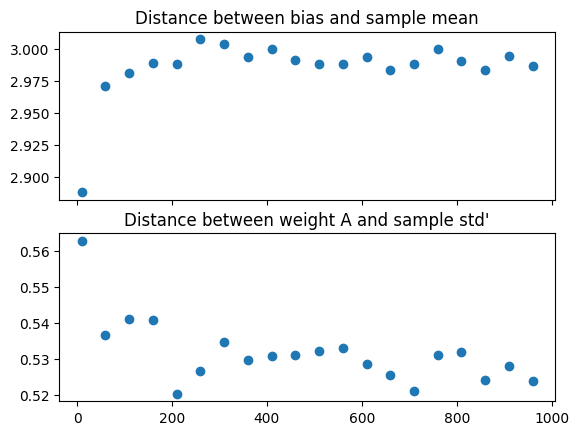

In [15]:
fig, axs = plt.subplots(2, sharex = True)
axs[0].scatter(sample_sizes, estimated_b_avg)
#axs[0].set_ylim(-0.5,10)
axs[0].set_title("Distance between bias and sample mean") #Pas très lisible ...
axs[1].scatter(sample_sizes, estimated_A_avg)
#axs[1].set_ylim(-0.5,10)
axs[1].set_title("Distance between weight A and sample std'")


## Effect of initialization

### Mean

In [35]:
learning_rate = 1e-3
distances = [x for x in range(20)]
time_to_conv = [] #nb of iter in the training loop
errors = [] #distance between the final estimation and the actual mean
for distance in distances: #Decreasing the quality of the initialization
    transformation = T(np.log(sigma_x), mu_x+distance, torch.distributions.Normal(torch.Tensor([0.0]),torch.Tensor([1.0])))
    optimizer = torch.optim.SGD(transformation.parameters(), learning_rate)
    #Training
    stable_loss = False
    epsilon = 1e-4
    with torch.no_grad():
        previous_loss_test = transformation.L(X_test).mean().detach().item()
    time = n_iter
    for i in range(n_iter):
        #Computing train loss
        loss_train = transformation.L(X)
        #Optimizaton steps
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        if i%10 ==0: #We check the convergence every ten iterations
            with torch.no_grad():
                loss_test = transformation.L(X_test).mean().detach().item() #Loss on the test batch
            stable_loss = abs(loss_test - previous_loss_test) < epsilon
        if stable_loss:
            time = i
            break
        previous_loss_test = loss_test
    time_to_conv.append(time)
    errors.append(torch.abs(transformation.b - torch.mean(X)).item())

Text(0.5, 1.0, "Distance between the final mean estimation VS distance between the initialization of the mean and the true value'")

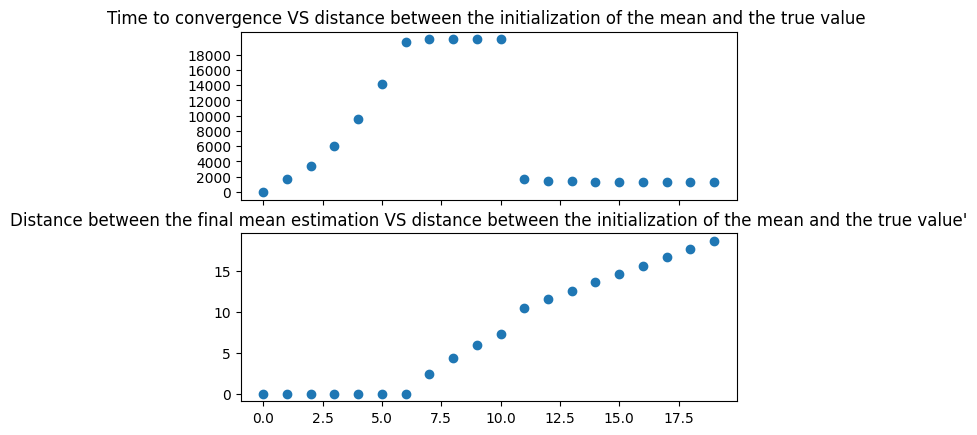

In [36]:
fig, axs = plt.subplots(2, sharex = True)
axs[0].scatter(distances, time_to_conv)
axs[0].yaxis.set_ticks(np.arange(0,max(time_to_conv),2000))
axs[0].set_title("Time to convergence VS distance between the initialization of the mean and the true value ")
axs[1].scatter(distances, errors)
axs[1].set_title("Distance between the final mean estimation VS distance between the initialization of the mean and the true value'")


At first the time to convergence increases as the initialization gets further from the true value of mu.
Then, the time to convergence decreases but the estimation gets worse. 

### Standard deviation

In [55]:
learning_rate = 1e-3
distances = [x for x in np.log(np.arange(1,10,0.25))]
time_to_conv = [] #nb of iter in the training loop
errors = [] #distance between the final estimation and the actual std
for distance in distances: #Decreasing the quality of the initialization
    transformation = T(np.log(sigma_x) + distance, mu_x, torch.distributions.Normal(torch.Tensor([0.0]),torch.Tensor([1.0])))
    optimizer = torch.optim.SGD(transformation.parameters(), learning_rate)
    #Training
    stable_loss = False
    epsilon = 1e-5
    with torch.no_grad():
        previous_loss_test = transformation.L(X_test).mean().detach().item()
    time = n_iter
    for i in range(n_iter):
        #Computing train loss
        loss_train = transformation.L(X)
        #Optimizaton steps
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        if i%10 ==0: #We check the convergence every ten iterations
            with torch.no_grad():
                loss_test = transformation.L(X_test).mean().detach().item() #Loss on the test batch
            stable_loss = abs(loss_test - previous_loss_test) < epsilon
        if stable_loss:
            time = i
            break
        previous_loss_test = loss_test
    time_to_conv.append(time)
    errors.append(torch.abs(torch.exp(transformation.alpha) - torch.std(X,unbiased=False)).item())

Text(0.5, 1.0, "Distance between the final std estimation VS distance between the initialization of the mean and the true value'")

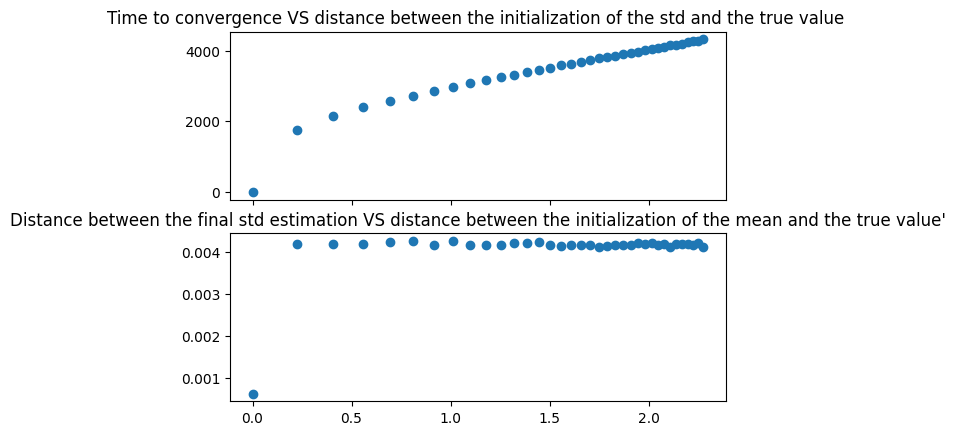

In [56]:
fig, axs = plt.subplots(2, sharex = True)
axs[0].scatter(distances, time_to_conv)
axs[0].yaxis.set_ticks(np.arange(0,max(time_to_conv),2000))
axs[0].set_title("Time to convergence VS distance between the initialization of the std and the true value ")
axs[1].scatter(distances, errors)
axs[1].set_title("Distance between the final std estimation VS distance between the initialization of the mean and the true value'")


The time to convergence increases as the initialization gets further from the true value, but contrary to the mean estimation the final estimation is consistent 

## What if if X is not gaussian (here chi2)

In [19]:
X_chi = np.random.chisquare(2, N)
X_chi = torch.from_numpy(X_chi)
X_chi = X_chi.reshape(X_chi.size()[0] , 1)
X_chi = X_chi.type(torch.float32)

In [20]:
transformation2 = T( 1, 1, torch.distributions.Normal(torch.Tensor([0.0]),torch.Tensor([1.0]))) #Instanciation
optimizer = torch.optim.SGD(transformation2.parameters(), learning_rate)

In [21]:
losses = []
estimated_A = []
estimated_b = []
for i in range(n_iter):
    #Computing & saving the loss
    loss = transformation2.L(X_chi).mean()
    losses.append(loss.detach().numpy().item())
    #optim
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #Saving parameters for later vizualisation
    A_hat, b_hat = torch.exp(transformation2.alpha).item(), transformation2.b.item()
    estimated_A.append(A_hat)
    estimated_b.append(b_hat)

In [22]:
A_hat, b_hat = estimated_A[-1], estimated_b[-1]
sample_mean = torch.mean(X_chi)
sample_sigma = torch.std(X_chi, unbiased=True)
print(f" Sample mean = {sample_mean} and b_hat = ", b_hat)
print(f" Sample std = {sample_sigma} and A_hat = ", A_hat)
print(f" Final loss = ", losses[-1])

 Sample mean = 2.067938804626465 and b_hat =  2.0590386390686035
 Sample std = 1.9996298551559448 and A_hat =  1.998679280281067
 Final loss =  2.11141037940979


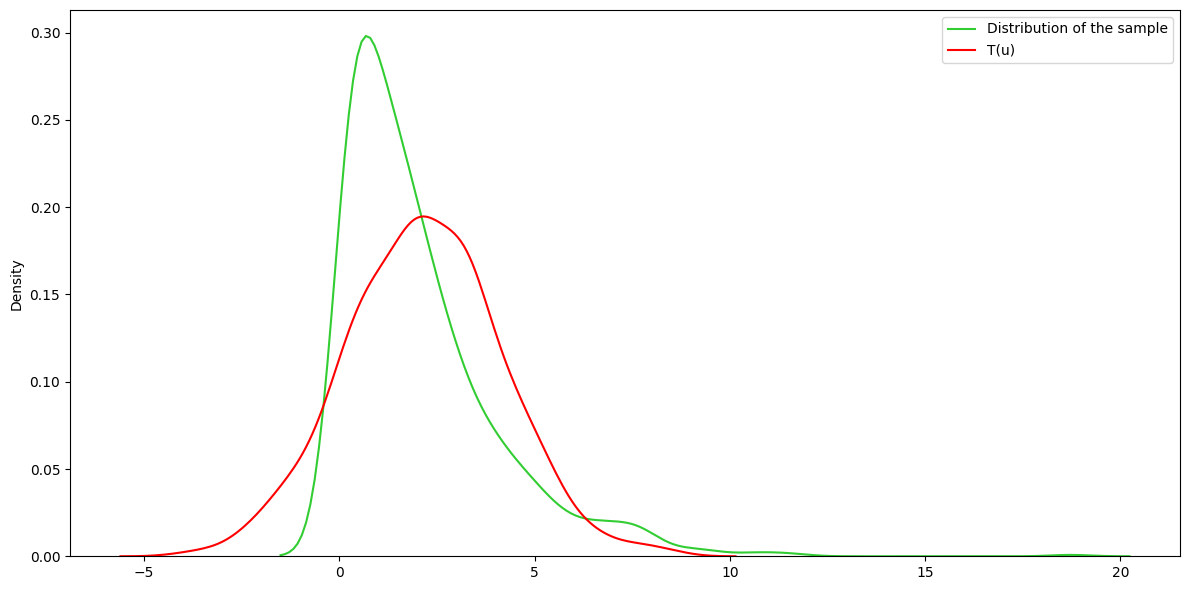

In [23]:
U = torch.distributions.Normal(0, 1).sample((N,1)) # True std Gaussian
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(data=X_chi.squeeze(),
            label='Distribution of the sample', ax=ax, color='limegreen')
sns.kdeplot(data= transformation2.forward(U)[0].detach().squeeze(), ax = ax, color='red', label='T(u)')
ax.legend()
plt.tight_layout()
plt.show()#TODO Overlayed avec un histo ?

In [24]:
#TODO Voir si on peut ajouter quelques  couches simples en se basant sur la description du papier 

# Planar Flow ?

In [474]:
class Sylvester(nn.Module):
    
    def __init__(self,prior, M): #TODO Changer l'init de b
        super().__init__()
        self.M = M
        self.b = nn.Parameter(torch.Tensor(1, M), requires_grad=True) # 
        self.v = nn.Parameter(torch.Tensor(1, M), requires_grad=True) 
        self.w = nn.Parameter(torch.Tensor(1, M), requires_grad=True) 
        self.activation_fct = torch.tanh
        
        self.prior = prior
        
        self.w.data.uniform_(0,10)
        self.v.data.uniform_(0,10)
        self.b.data.uniform_(0,10)
        
        
        
    def forward(self, z):
        z_prime = torch.zeros_like(z)
        det = 0
        for i in range(z.shape[0]):
            intermediate = torch.matmul(self.w.T, z[i].unsqueeze(-1)).squeeze() + self.b
            z_prime[i] =  z[i] +  torch.matmul(self.v ,  self.activation_fct(intermediate).T)

            det += torch.eye(self.M) + torch.matmul( torch.eye(self.M) * ((1-self.activation_fct(intermediate)**2)),   torch.matmul(self.w.T,  self.v))
        return z_prime, torch.log(torch.abs(torch.det(det)))
        
    def loss(self, z):
        
        z_prime, log_det = self.forward(z)
        log_prob = self.prior.log_prob(z_prime)
        return -log_prob.mean() + log_det.mean()

In [475]:
test = Sylvester(prior,3)
test.loss(X)

tensor(286.5666, grad_fn=<AddBackward0>)

In [476]:
flows  = Sylvester(prior, 8)
learning_rate = 1e-3
optimizer = torch.optim.Adam(flows.parameters(), learning_rate)
n_iter = 500

In [477]:
from torch.utils.data import TensorDataset, DataLoader

In [478]:
dataset = TensorDataset(X)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [481]:
# Keeping records of these values for later visualisations
losses_train = []
stable_loss = False
epsilon = 1e-4 # IF distance(Loss(test_time_k) ; (test_time_k+1)) < epsilon we stop the training, the convergence is "achieved"
with torch.no_grad():
    previous_loss_test = flows.loss(X_test).mean().detach().item()
    
for i in range(n_iter):
    for j, batch in enumerate(dataloader):
    
        #Computing train loss
        loss_train = flows.loss(batch[0])
        losses_train.append(loss_train.detach().item())
        
        #Optimizaton steps
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
    if i%10 == 0:
        print(f"Iter {i}, loss = {loss_train}")
    #Is convergence achieved?
    if i%10 ==0: #We check the convergence every ten iterations
        with torch.no_grad():
            loss_test = flows.loss(X_test).mean().detach().item() #Loss on the test batch
        stable_loss = abs(loss_test - previous_loss_test) < epsilon
        if stable_loss:
            print(f"Early stop at iteration {i}")
            break
        previous_loss_test = loss_test

Iter 0, loss = 16.383787155151367
Iter 10, loss = 16.526002883911133
Iter 20, loss = 16.646276473999023
Iter 30, loss = 16.78148078918457
Iter 40, loss = 17.95469093322754
Iter 50, loss = 15.627687454223633
Iter 60, loss = 16.03887939453125
Iter 70, loss = 16.470670700073242
Iter 80, loss = 16.01523780822754
Iter 90, loss = 16.97095489501953
Iter 100, loss = 16.07455062866211
Iter 110, loss = 15.166489601135254
Iter 120, loss = 16.784582138061523
Iter 130, loss = 17.14803695678711
Iter 140, loss = 16.82483673095703
Iter 150, loss = 16.427072525024414
Iter 160, loss = 15.643705368041992
Iter 170, loss = 16.915788650512695
Iter 180, loss = 16.568403244018555
Iter 190, loss = 16.992971420288086
Iter 200, loss = 15.172966957092285
Iter 210, loss = 14.480366706848145
Iter 220, loss = 17.188343048095703
Iter 230, loss = 15.71712589263916
Iter 240, loss = 16.96295166015625
Iter 250, loss = 15.808830261230469
Iter 260, loss = 16.824064254760742
Iter 270, loss = 16.959280014038086
Iter 280, los

In [ ]:
#TODO Batch norm

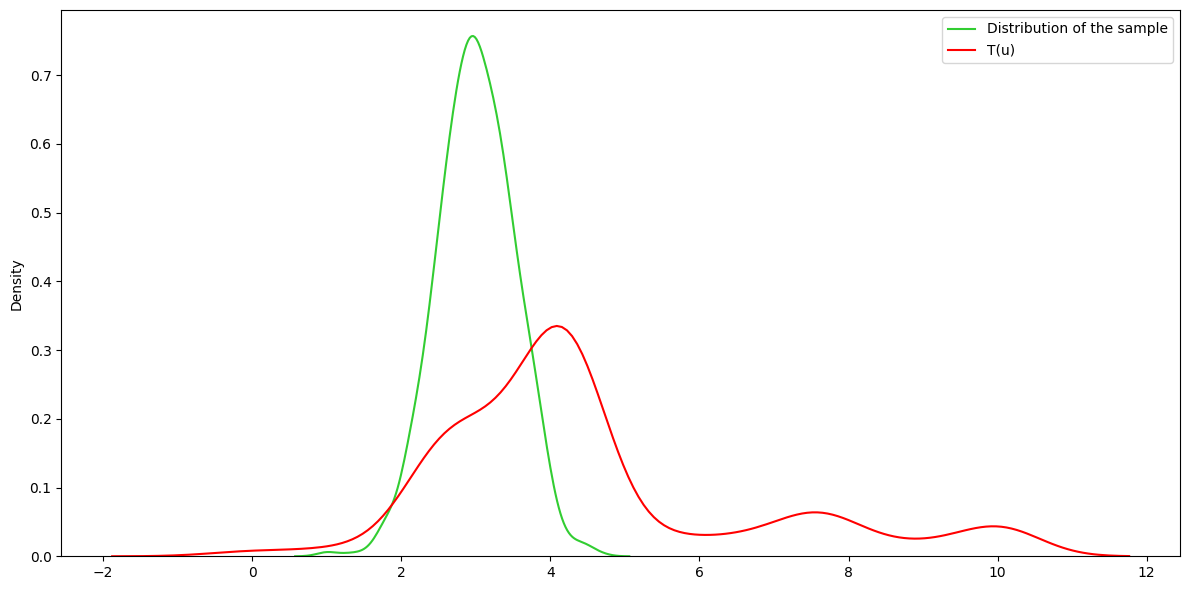

In [482]:
U = torch.distributions.Normal(0, 1).sample((N,1)) # True std Gaussian
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(data=X.squeeze(),
            label='Distribution of the sample', ax=ax, color='limegreen')
sns.kdeplot(data= flows.forward(U)[0].detach().squeeze(), ax = ax, color='red', label='T(u)')
ax.legend()
plt.tight_layout()
plt.show()